In [1]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [2]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.0 MB/s eta 0:00:00


In [3]:
 from google.colab import drive
 drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import cv2
from google.colab.patches import cv2_imshow
import segment_anything
import supervision as sv
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load a SAM model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_type = "vit_h"  # Model type can be 'vit_h', 'vit_l', or 'vit_b' (larger models may perform better but are slower)
sam = sam_model_registry[model_type](checkpoint="/content/gdrive/MyDrive/CompVision/sam_vit_h_4b8939.pth")
sam.to(device);

total # frames: 1503
True


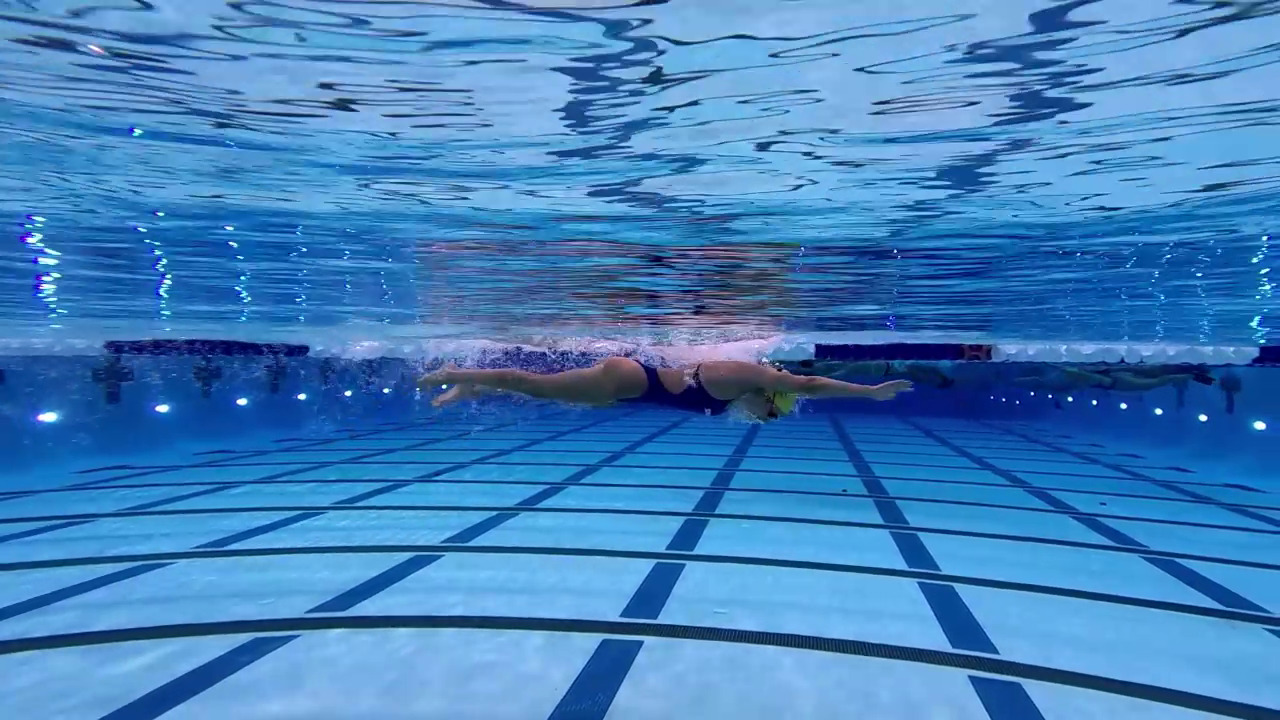

In [5]:
#Manually segment frames, change selectedframe

selectedframe=120 #current frame number we want to perform segmentation on
#input_video = "/content/gdrive/MyDrive/CompVision/Swim_InputVideo.mp4"
input_video = "/content/gdrive/MyDrive/CompVision/classificationvideos/BR.mp4"
currentframepath= "/content/gdrive/MyDrive/CompVision/BR_frames"
segframepath= "/content/gdrive/MyDrive/CompVision/BR_seg"

def FrameCapture():
    global selectedframe
    count = 0
    # Path to video file
    vidObj = cv2.VideoCapture(input_video)
    print("total # frames:",int(vidObj.get(cv2.CAP_PROP_FRAME_COUNT)))
    success = 1
    while success == 1:
        # vidObj object calls read
        # function extract frames
        success, image = vidObj.read()
        # Saves the frames with frame-count
        if count == selectedframe:

            success = cv2.imwrite(f"{currentframepath}/frame{count}.jpg", image)
            print(success)
            return(image)
            break

        count += 1


image = FrameCapture()
cv2_imshow(image)
print(selectedframe)
image_bgr = image
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [6]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(f"{currentframepath}/frame{selectedframe}.jpg")
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

True

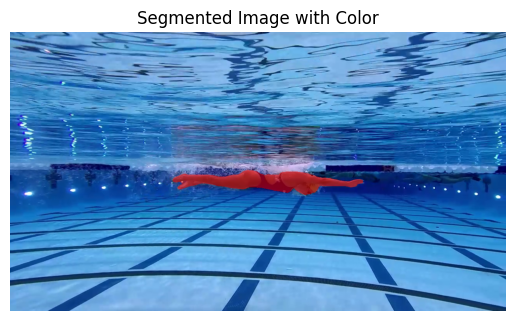

In [7]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 205, 'y': 182, 'width': 1496, 'height': 792, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

mask_predictor = SamPredictor(sam)
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=False
)

box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
'''
sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)'''

plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title("Segmented Image with Color")
plt.axis("off")
cv2.imwrite(f"{segframepath}/segmentedframe{selectedframe}.jpg", segmented_image)

In [ ]:
#converting frames to video not neccessary to execute before pose estimation
!pip install natsort

In [ ]:
import cv2
import os
from pathlib import Path
from natsort import natsorted  # For natural sorting of filenames

def images_to_video(input_folder, output_video_path, fps=2):
    """
    Convert images to a video.

    Args:
        input_folder (str): Path to the folder containing images.
        output_video_path (str): Path to save the output video.
        fps (int): Frames per second for the output video.
    """
    # Get list of image files sorted by natural order (e.g., frame_0, frame_1)
    input_folder = Path(input_folder)
    image_files = natsorted([str(file) for file in input_folder.glob("segmentedframe*.jpg")])

    if not image_files:
        print("No images found in the input folder!")
        return

    # Read the first image to get dimensions
    first_frame = cv2.imread(image_files[0])
    height, width, _ = first_frame.shape

    # Initialize the VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Write each image to the video
    for image_file in image_files:
        frame = cv2.imread(image_file)
        if frame is None:
            print(f"Skipping {image_file} (not a valid image)")
            continue
        video_writer.write(frame)

    # Release the video writer
    video_writer.release()
    print(f"Video saved to {output_video_path}")

# Paths
input_folder = '/content/gdrive/MyDrive/CompVision/seg/'
# Change to your folder containing images
output_video_path = "/content/gdrive/MyDrive/CompVision/seg/with_seg_output_video.mp4"  # Change to your desired output path

# Create video
images_to_video(input_folder, output_video_path)

Video saved to /content/gdrive/MyDrive/CompVision/BK_seg/BKoutput_seg_video.mp4
